# Condition-based solution

In [127]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.preprocessing.utils import train_val_split

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score,
    classification_report,
    ConfusionMatrixDisplay,
)

## Loading the data

In [139]:
train_df = pd.read_csv('../data/raw/loan-data.csv')
train_df.dropna(inplace=True)
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [141]:
train_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [142]:
train_df["Loan_Status"] = np.where(train_df.Loan_Status == 'Y', 1, 0)
train_df.Loan_Status

1      0
2      1
3      1
4      1
5      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 480, dtype: int32

## Feature engineering

In [143]:
train_df["Monthly_Payment"] = train_df.LoanAmount / train_df.Loan_Amount_Term
train_df["Total_Income"] = train_df.ApplicantIncome + train_df.CoapplicantIncome

train_df["Amount_Income_Ratio"] = train_df.Monthly_Payment  / train_df.Total_Income

# Map the values between 0 and 100%
min_value = train_df["Amount_Income_Ratio"].min()
max_value = train_df["Amount_Income_Ratio"].max()

train_df["Amount_Income_Ratio_Percent"] = ((train_df["Amount_Income_Ratio"] - min_value) / (max_value - min_value)) * 100

train_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Monthly_Payment,Total_Income,Amount_Income_Ratio,Amount_Income_Ratio_Percent
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,0.355556,6091.0,0.000058,4.176541
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,0.183333,3000.0,0.000061,4.399101
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,0.333333,4941.0,0.000067,4.915549
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,0.391667,6000.0,0.000065,4.737892
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1,0.741667,9613.0,0.000077,5.703420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,1,0.197222,2900.0,0.000068,4.959858
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1,0.222222,4106.0,0.000054,3.830765
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1,0.702778,8312.0,0.000085,6.304893
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1,0.519444,7583.0,0.000069,4.999986


## Conditions

1. If the applicant does not have a credit history, then the loan is rejected.
2. If the applicant has a credit history:
    - If their total income is less than 2500, then the loan is rejected.
    - If their total income is greater than 2500:
        - If the loan amount to income ratio is greater than 0.5, then the loan is rejected.

Income-to-Loan Amount Ratio = (ApplicantIncome + CoapplicantIncome) / (LoanAmount / Loan_Amount_Term)

In [144]:
train_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Monthly_Payment,Total_Income,Amount_Income_Ratio,Amount_Income_Ratio_Percent
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,5364.231250,1581.093583,144.735417,342.050000,0.854167,0.691667,0.459267,6945.324833,0.000076,5.606431
std,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.462287,0.367847,5969.948374,0.000069,5.650608
min,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.025000,1442.000000,0.000007,0.000000
25%,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.285417,4148.000000,0.000056,3.946199
50%,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,0.366667,5422.500000,0.000069,5.011993
75%,5852.500000,2253.250000,170.000000,360.000000,1.000000,1.000000,0.513889,7672.500000,0.000082,6.067578
max,81000.000000,33837.000000,600.000000,480.000000,1.000000,1.000000,4.305556,81000.000000,0.001237,100.000000


In [145]:
# Iterate over the rows
for idx, row in train_df.iterrows():
    # No credit history, not approved
    if row["Credit_History"] == 0:
        train_df.loc[idx, "Predicted_Status"] = 0
        continue

    # Total income is less than 250, not approved
    if train_df.loc[idx, "Total_Income"] < 250:
        train_df.loc[idx, "Predicted_Status"] = 0
        continue

    # Amount income ratio is less than 3%, not approved
    if train_df.loc[idx, "Amount_Income_Ratio_Percent"] < 3:
        train_df.loc[idx, "Predicted_Status"] = 0
        continue
    
    # Otherwise, approved
    train_df.loc[idx, "Predicted_Status"] = 1

train_df[["Loan_Status", "Predicted_Status"]]

,Loan_Status,Predicted_Status
1,0,1.0
2,1,1.0
3,1,1.0
4,1,1.0
5,1,1.0
...,...,...
609,1,1.0
610,1,1.0
611,1,1.0
612,1,1.0


## Evaluation

### Single Condition

Evaluating the prediction using only "Credit_History" as a condition.

In [146]:
y_true = train_df.Loan_Status.values
y_pred = np.where(train_df.Credit_History == 1, 1, 0)

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.43      0.58       148
           1       0.79      0.98      0.88       332

    accuracy                           0.81       480
   macro avg       0.85      0.70      0.73       480
weighted avg       0.83      0.81      0.78       480



Text(0.5, 1.0, 'Single condition model')

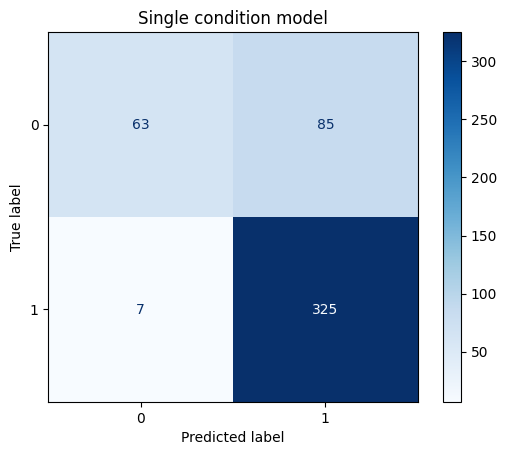

In [147]:
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, cmap='Blues'
)
plt.title("Single condition model")

### Multiple Conditions

Evaluating the predictions using the specifed conditions.

In [148]:
y_true = train_df.Loan_Status.values
y_pred = train_df.Predicted_Status.values

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.49      0.55       148
           1       0.79      0.87      0.83       332

    accuracy                           0.75       480
   macro avg       0.71      0.68      0.69       480
weighted avg       0.74      0.75      0.74       480



Text(0.5, 1.0, 'Multiple conditions model')

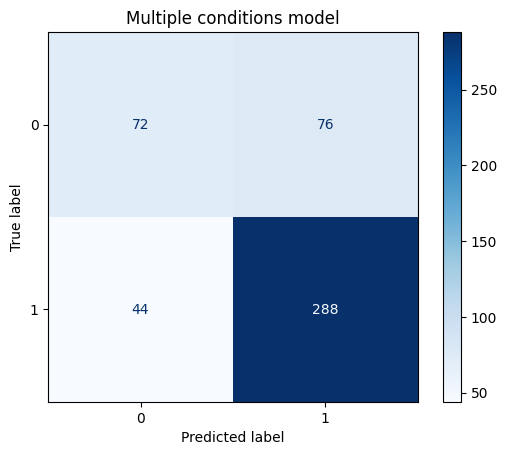

In [149]:
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, cmap='Blues',
)
plt.title("Multiple conditions model")